In [ ]:
# Core packages
pip install networkx
pip install python-arango

# The NetworkX-ArangoDB integration package
pip install nx-arangodb

# Support packages for data handling and visualization
pip install pandas
pip install matplotlib

# Database connectivity (if you need PostgreSQL)
pip install psycopg2-binary

# Utility packages
pip install tqdm
pip install scipy

# If you need LangChain integration
pip install langchain langchain-openai


## Database Connection & Initial Queries

In [11]:
import os
import psycopg2
import pandas as pd
import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient





In [ ]:
os.environ["DATABASE_HOST"] = "https://b2f7971c2b5a.arangodb.cloud:8529"
os.environ["DATABASE_USERNAME"] = "root"
os.environ["DATABASE_PASSWORD"] = ""
os.environ["DATABASE_NAME"] = "_system"
os.environ["OPENAI_API_KEY"]= ""

def connect_db():# PostgreSQL Connection Configuration
    DB_CONFIG = {
        "dbname": "musicbrainz_db",
        "user": "musicbrainz",
        "password": "",  # Set if needed
        "host": "localhost",
        "port": 5432,
    }
    # Connect to the PostgreSQL database
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("✅ Connected to PostgreSQL")
        return conn
    except Exception as e:
        print("❌ Connection failed:", e)
        raise e
# --- Close PostgreSQL Connection ---
def close_db(conn):
    """Closes the database connection."""
    if conn:
        conn.close()
        print("🔒 Database connection closed.")

In [13]:

conn = connect_db()
# --- Fetch Covers ---
query_covers = """
SELECT 
    a1.name AS performer,
    a2.name AS first_performed_work,
    'first_performer' AS relationship_type
FROM musicbrainz.l_artist_work law
JOIN musicbrainz.artist a1 ON law.entity0 = a1.id
JOIN musicbrainz.l_recording_work lrw ON law.entity1 = lrw.entity1
JOIN musicbrainz.l_artist_recording lar2 ON lrw.entity0 = lar2.entity1
JOIN musicbrainz.artist a2 ON lar2.entity0 = a2.id
WHERE lrw.link IN (
    SELECT id FROM musicbrainz.link WHERE link_type IN (
        SELECT id FROM musicbrainz.link_type WHERE name = 'performance'
    )
)
LIMIT 200000;
"""

print("⏳ Fetching covers...")
df_covers = pd.read_sql_query(query_covers, conn)
print(f"✅ Retrieved {len(df_covers)} cover relationships")

# --- Fetch Samples ---
query_samples = """
SELECT 
    a1.name AS sampled_artist, 
    a2.name AS sampling_artist,
    'sample' AS relationship_type
FROM musicbrainz.l_recording_recording lrr
JOIN musicbrainz.recording r1 ON lrr.entity0 = r1.id
JOIN musicbrainz.l_artist_recording lar1 ON r1.id = lar1.entity1
JOIN musicbrainz.artist a1 ON lar1.entity0 = a1.id
JOIN musicbrainz.recording r2 ON lrr.entity1 = r2.id
JOIN musicbrainz.l_artist_recording lar2 ON r2.id = lar2.entity1
JOIN musicbrainz.artist a2 ON lar2.entity0 = a2.id
WHERE lrr.link IN (69, 231)
LIMIT 100000;
"""
print("⏳ Fetching samples...")
df_samples = pd.read_sql_query(query_samples, conn)
print(f"✅ Retrieved {len(df_samples)} sample relationships")

# --- Fetch First Performers ---
query_first_performers = """
SELECT 
    a.name AS first_performer, 
    w.name AS work_name, 
    'first_performer' AS relationship_type
FROM musicbrainz.artist a
JOIN musicbrainz.l_artist_work law ON a.id = law.entity0
JOIN musicbrainz.work w ON law.entity1 = w.id
WHERE law.link IN (34, 122, 278, 887)
LIMIT 100000;
"""
print("⏳ Fetching first performers...")
df_first_performers = pd.read_sql_query(query_first_performers, conn)
print(f"✅ Retrieved {len(df_first_performers)} first performer relationships")

# --- Fetch Songwriters ---
query_songwriters = """
SELECT 
    a.name AS songwriter,
    w.name AS work_name,
    'songwriter' AS relationship_type
FROM musicbrainz.artist a
JOIN musicbrainz.l_artist_work law ON a.id = law.entity0
JOIN musicbrainz.work w ON law.entity1 = w.id
WHERE law.link IN (54, 55, 167, 168)
LIMIT 50000;
"""
print("⏳ Fetching songwriters...")
df_songwriters = pd.read_sql_query(query_songwriters, conn)
print(f"✅ Retrieved {len(df_songwriters)} songwriter relationships")

# --- Fetch Artist-Genre Relationships ---
query_artist_genres = """
SELECT 
    a.name AS artist_name, 
    g.name AS genre_name,
    'belongs_to_genre' AS relationship_type
FROM musicbrainz.artist a
JOIN musicbrainz.l_artist_genre lag ON a.id = lag.entity0
JOIN musicbrainz.genre g ON lag.entity1 = g.id
LIMIT 200000;
"""

print("⏳ Fetching artist-genre relationships...")
df_artist_genres = pd.read_sql_query(query_artist_genres, conn)
print(f"✅ Retrieved {len(df_artist_genres)} artist-genre relationships")

query_artist_recordings = """
SELECT 
    a.name AS artist_name, 
    r.name AS recording_name, 
    lt.name AS relationship_type
FROM musicbrainz.l_artist_recording lar
JOIN musicbrainz.artist a ON lar.entity0 = a.id
JOIN musicbrainz.recording r ON lar.entity1 = r.id
JOIN musicbrainz.link l ON lar.link = l.id
JOIN musicbrainz.link_type lt ON l.link_type = lt.id
WHERE lt.name IN (
    'performer', 'instrument', 'vocal', 'producer', 
    'remixer', 'mix-DJ', 'mastering', 'arranger', 'sound'
)
LIMIT 200000;
"""

# --- Fetch Artist-Recording Relationships ---
print("⏳ Fetching artist-recording relationships...")
df_artist_recordings = pd.read_sql_query(query_artist_recordings, conn)
print(f"✅ Retrieved {len(df_artist_recordings)} artist-recording relationships")


query_artist_collaborations = """
SELECT 
    a1.name AS artist_1, 
    a2.name AS artist_2, 
    'collaboration' AS relationship_type
FROM musicbrainz.l_artist_artist laa
JOIN musicbrainz.artist a1 ON laa.entity0 = a1.id
JOIN musicbrainz.artist a2 ON laa.entity1 = a2.id
JOIN musicbrainz.link l ON laa.link = l.id
JOIN musicbrainz.link_type lt ON l.link_type = lt.id
WHERE lt.name IN ('collaboration', 'supporting musician', 'member of band')
LIMIT 200000;
"""

print("⏳ Fetching artist collaborations...")
df_collaborations = pd.read_sql_query(query_artist_collaborations, conn)
print(f"✅ Retrieved {len(df_collaborations)} artist collaborations")

query_recording_relationships="""
SELECT 
    r1.name AS original_recording, 
    r2.name AS derived_recording, 
    lt.name AS relationship_type
FROM musicbrainz.l_recording_recording lrr
JOIN musicbrainz.recording r1 ON lrr.entity0 = r1.id
JOIN musicbrainz.recording r2 ON lrr.entity1 = r2.id
JOIN musicbrainz.link l ON lrr.link = l.id
JOIN musicbrainz.link_type lt ON l.link_type = lt.id
WHERE lt.name IN ('compilation', 'DJ-mix', 'remix', 'samples material', 'mashes up')
LIMIT 200000;

"""

# --- Fetch Recording-Recording Remixes/Samples ---
print("⏳ Fetching recording relationships (remixes, samples, etc.)...")
df_recording_relationships = pd.read_sql_query(query_recording_relationships, conn)
print(f"✅ Retrieved {len(df_recording_relationships)} recording-to-recording relationships")

# --- Fetch Genre-to-Genre Relationships ---
query_genre_genre = """
SELECT 
    g1.name AS genre_1, 
    g2.name AS genre_2, 
    lt.name AS relationship_type
FROM musicbrainz.l_genre_genre lgg
JOIN musicbrainz.genre g1 ON lgg.entity0 = g1.id
JOIN musicbrainz.genre g2 ON lgg.entity1 = g2.id
JOIN musicbrainz.link l ON lgg.link = l.id
JOIN musicbrainz.link_type lt ON l.link_type = lt.id
WHERE lt.name IN ('subgenre', 'influenced by', 'fusion of')
LIMIT 50000;
"""

print("⏳ Fetching genre-to-genre relationships...")
df_genre_genre = pd.read_sql_query(query_genre_genre, conn)
print(f"✅ Retrieved {len(df_genre_genre)} genre relationships")


# Close database connection

# Display the graph summary


✅ Connected to PostgreSQL
⏳ Fetching covers...


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_covers = pd.read_sql_query(query_covers, conn)


✅ Retrieved 200000 cover relationships
⏳ Fetching samples...
✅ Retrieved 0 sample relationships
⏳ Fetching first performers...


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_samples = pd.read_sql_query(query_samples, conn)
/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_first_performers = pd.read_sql_query(query_first_performers, conn)


✅ Retrieved 0 first performer relationships
⏳ Fetching songwriters...
✅ Retrieved 0 songwriter relationships
⏳ Fetching artist-genre relationships...


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_songwriters = pd.read_sql_query(query_songwriters, conn)
/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:90: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_artist_genres = pd.read_sql_query(query_artist_genres, conn)


✅ Retrieved 200000 artist-genre relationships
⏳ Fetching artist-recording relationships...


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:112: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_artist_recordings = pd.read_sql_query(query_artist_recordings, conn)


✅ Retrieved 200000 artist-recording relationships
⏳ Fetching artist collaborations...


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:131: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_collaborations = pd.read_sql_query(query_artist_collaborations, conn)


✅ Retrieved 200000 artist collaborations
⏳ Fetching recording relationships (remixes, samples, etc.)...


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:151: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_recording_relationships = pd.read_sql_query(query_recording_relationships, conn)


✅ Retrieved 181572 recording-to-recording relationships
⏳ Fetching genre-to-genre relationships...
✅ Retrieved 3198 genre relationships


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/185730250.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_genre_genre = pd.read_sql_query(query_genre_genre, conn)


## Creation of the graph

In [14]:
# Combine all data into a single DataFrame
df_all = pd.concat([df_covers, df_samples, df_first_performers, df_songwriters, df_artist_genres], ignore_index=True)

# --- Create Graph ---
print("⏳ Creating influence graph...")
G = nx.DiGraph()

# --- Step 1: Add Artist and Work Relationships (Directed) ---
for _, row in df_all.iterrows():
    if row[2] in ['first_performer', 'sample', 'songwriter']:
        if row[0] not in G:
            G.add_node(row[0], node_type='artist', name=row[0])  # Ensure artist exists
        if row[1] not in G:
            node_type = 'work' if 'work' in row else 'artist'
            G.add_node(row[1], node_type=node_type, name=row[1])  # Ensure work/artist exists
        
        G.add_edge(row[0], row[1], relationship=row[2])

# --- Step 2: Add Artist-Genre Relationships (Directed) ---
for _, row in df_artist_genres.iterrows():
    artist = row["artist_name"]
    genre = row["genre_name"]

    if artist not in G:
        G.add_node(artist, node_type="artist", name=artist)  # Ensure artist node exists
    
    if genre not in G:
        G.add_node(genre, node_type="genre", name=genre)  # Ensure genre node exists
    
    G.add_edge(artist, genre, relationship="belongs_to_genre")  # Artist → Genre
    G.add_edge(genre, artist, relationship="influences")  # Genre → Artist

# --- Update Graph with Artist-Recording Edges ---
for _, row in df_artist_recordings.iterrows():
    artist, recording, rel_type = row["artist_name"], row["recording_name"], row["relationship_type"]

    if artist not in G:
        G.add_node(artist, node_type="artist", name=artist)  # Ensure artist exists
    
    if recording not in G:
        G.add_node(recording, node_type="recording", name=recording)  # Ensure recording exists

    G.add_edge(artist, recording, relationship=rel_type, directed=True)

# --- Update Graph with Artist → Artist (Collaboration) Edges ---
for _, row in df_collaborations.iterrows():
    artist1, artist2 = row["artist_1"], row["artist_2"]
    
    if artist1 not in G:
        G.add_node(artist1, node_type="artist", name=artist1)  # Ensure artist1 exists
    if artist2 not in G:
        G.add_node(artist2, node_type="artist", name=artist2)  # Ensure artist2 exists

    G.add_edge(artist1, artist2, relationship="collaboration", directed=False)

# --- Update Graph with Recording → Recording (Remix/Sample) Edges ---
for _, row in df_recording_relationships.iterrows():
    original, derived, rel_type = row["original_recording"], row["derived_recording"], row["relationship_type"]
    
    if original not in G:
        G.add_node(original, node_type="recording", name=original)  # Ensure recording exists
    if derived not in G:
        G.add_node(derived, node_type="recording", name=derived)  # Ensure recording exists

    G.add_edge(original, derived, relationship=rel_type, directed=True)

# --- Step: Add Genre-to-Genre Edges ---
for _, row in df_genre_genre.iterrows():
    genre1, genre2, rel_type = row["genre_1"], row["genre_2"], row["relationship_type"]

    if genre1 not in G:
        G.add_node(genre1, node_type="genre", name=genre1)  # Ensure genre node exists
    if genre2 not in G:
        G.add_node(genre2, node_type="genre", name=genre2)  # Ensure genre node exists

    if rel_type == "subgenre":
        G.add_edge(genre1, genre2, relationship="subgenre")  # Genre1 → Genre2 (Subgenre)
    elif rel_type == "influenced by":
        G.add_edge(genre2, genre1, relationship="influences")  # Genre2 → Genre1 (Influence direction)
    elif rel_type == "fusion of":
        G.add_edge(genre1, genre2, relationship="fusion")  # Fusion between genres

print(f"✅ Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


⏳ Creating influence graph...


/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/2283816506.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[2] in ['first_performer', 'sample', 'songwriter']:
/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/2283816506.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in G:
/var/folders/f1/vcc52pv15lz1xrwzg4bzd4rm0000gn/T/ipykernel_21161/2283816506.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by pos

✅ Graph created with 644370 nodes and 1014875 edges


## Arango Persistence

In [15]:
# Function to Load or Initialize the Graph
def load_or_initialize_graph():
    global G

    if "G" in globals() and G and G.number_of_nodes() > 0:
        print("✅ Using existing in-memory graph.")
    else:
        print("⏳ Graph not found in memory. Loading from ArangoDB...")
        try:
            G = nxadb(name="MusicDiscovery", db=db)
            print(f"✅ Graph loaded from ArangoDB with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        except Exception as e:
            print(f"⚠️ Failed to load graph from ArangoDB: {e}")
            print("🔄 Initializing a new empty graph.")
            G = nx.DiGraph()  # Create a new empty graph if ArangoDB load fails

# Call the function to ensure `G` is set correctly
load_or_initialize_graph()

✅ Using existing in-memory graph.


In [ ]:
# --- Step 1: Connect to ArangoDB ---
client = ArangoClient(hosts=os.environ["DATABASE_HOST"])
sys_db = client.db("_system", username=os.environ["DATABASE_USERNAME"], password=os.environ["DATABASE_PASSWORD"])

db_name = "MusicBrainzData"
if not sys_db.has_database(db_name):
    sys_db.create_database(db_name)

db = client.db(db_name, username=os.environ["DATABASE_USERNAME"], password=os.environ["DATABASE_PASSWORD"])

In [ ]:
# --- Step 2: Persist the NetworkX Graph to ArangoDB ---
G_adb = nxadb.Graph(
    name="MusicDiscovery",
    db=db,  # ✅ Pass the database object instead of a string
    incoming_graph_data=G,
    overwrite_graph=False
)

print(f"✅ Graph persisted with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(G_adb)


## Artist Metadata

In [ ]:
query_artist_urls = """
SELECT 
    a.name AS artist_name, 
    u.url, 
    lt.name AS url_type
FROM musicbrainz.l_artist_url lau
JOIN musicbrainz.artist a ON lau.entity0 = a.id
JOIN musicbrainz.url u ON lau.entity1 = u.id
JOIN musicbrainz.link l ON lau.link = l.id
JOIN musicbrainz.link_type lt ON l.link_type = lt.id
WHERE lt.name IN ('wikipedia', 'biography', 'image')
LIMIT 50000;
"""
conn = connect_db()
print("⏳ Fetching artist URLs...")
df_artist_urls = pd.read_sql_query(query_artist_urls, conn)
print(f"✅ Retrieved {len(df_artist_urls)} artist URLs")

for _, row in df_artist_urls.iterrows():
    artist, url, url_type = row["artist_name"], row["url"], row["url_type"]

    if artist in G:
        if url_type == "wikipedia":
            G.nodes[artist]["wikipedia"] = url
        elif url_type == "biography":
            G.nodes[artist]["biography"] = url
        elif url_type == "image":
            G.nodes[artist]["image"] = url

print("✅ Artist URLs added to the graph")
close_db(conn)

update_arango(G)



## Display the Graph

/Users/uthmanoali98/Desktop/musicbrainz_data/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31119 (\N{CJK UNIFIED IDEOGRAPH-798F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/uthmanoali98/Desktop/musicbrainz_data/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/uthmanoali98/Desktop/musicbrainz_data/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20581 (\N{CJK UNIFIED IDEOGRAPH-5065}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/uthmanoali98/Desktop/musicbrainz_data/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22826 (\N{CJK UNIFIED IDEOGRAPH-592A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/uthmanoal

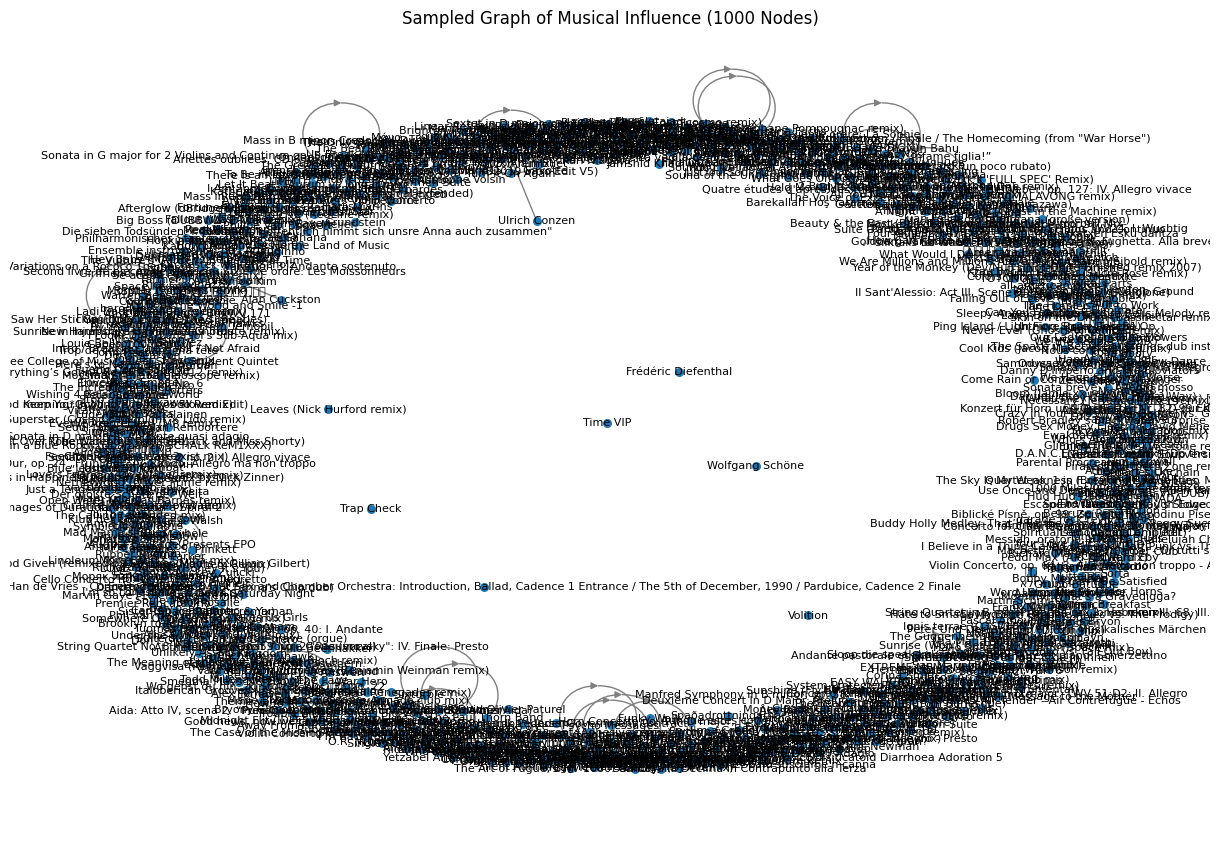

In [ ]:
import random
import matplotlib.pyplot as plt

sample_size = 1000  # Adjust as needed
sampled_nodes = random.sample(list(G.nodes), min(sample_size, len(G.nodes)))
subgraph = G.subgraph(sampled_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for better visualization
nx.draw(subgraph, pos, with_labels=True, node_size=30, font_size=8, edge_color="gray")

plt.title(f"Sampled Graph of Musical Influence ({len(subgraph.nodes)} Nodes)")
plt.show()

## 🎭 1. Most Influential Artists (PageRank & Degree Centrality)


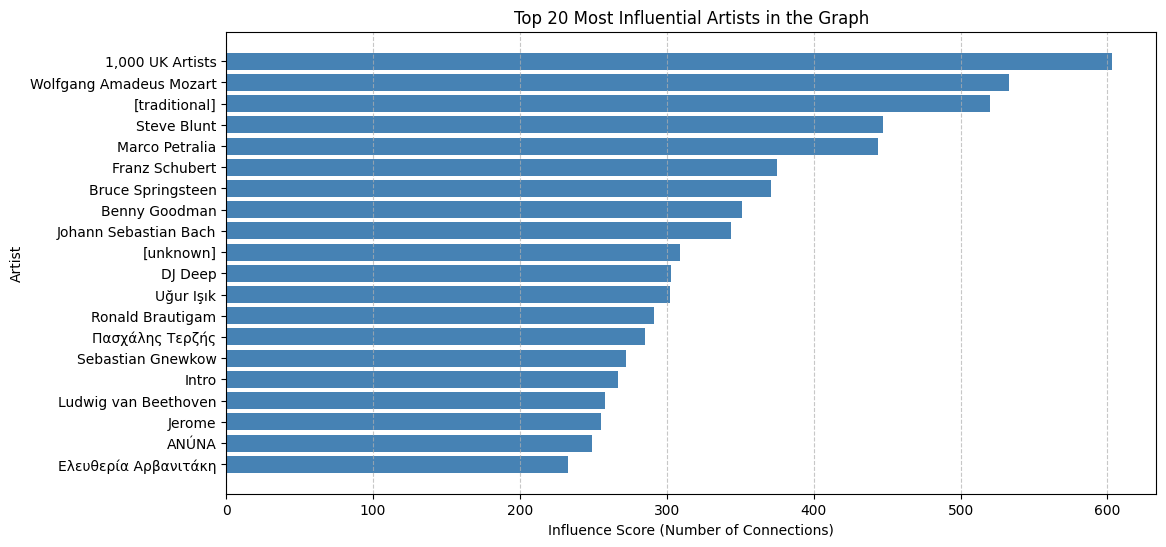

In [38]:
import matplotlib.pyplot as plt

# Compute artist influence (degree centrality)
artist_influence = {
    node: G.degree(node) for node, data in G.nodes(data=True) if data["node_type"] == "artist"
}

# Sort by influence
top_artists = sorted(artist_influence.items(), key=lambda x: x[1], reverse=True)[:20]  

# Extract artist names and their influence scores
artists, scores = zip(*top_artists)

# --- Plot the Bar Chart ---
plt.figure(figsize=(12, 6))
plt.barh(artists[::-1], scores[::-1], color="steelblue")  # Reverse for better visualization

plt.xlabel("Influence Score (Number of Connections)")
plt.ylabel("Artist")
plt.title("Top 20 Most Influential Artists in the Graph")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()


## 🎸 2. Most Popular Genres (Based on Artist Connections)


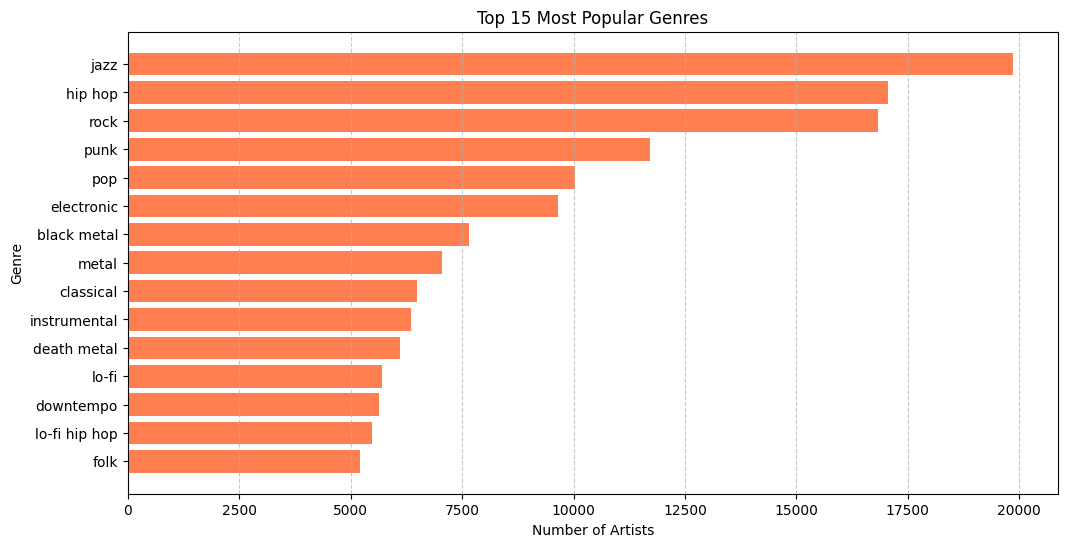

In [20]:
# Compute genre influence
genre_influence = {
    node: G.degree(node) for node, data in G.nodes(data=True) if data["node_type"] == "genre"
}

# Sort by number of artists
top_genres = sorted(genre_influence.items(), key=lambda x: x[1], reverse=True)[:15]

# Extract genre names and number of artists
genres, num_artists = zip(*top_genres)

# --- Plot the Bar Chart ---
plt.figure(figsize=(12, 6))
plt.barh(genres[::-1], num_artists[::-1], color="coral")  # Reverse for better visualization

plt.xlabel("Number of Artists")
plt.ylabel("Genre")
plt.title("Top 15 Most Popular Genres")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()


In [83]:
def fetch_genre_subgraph_from_arango(genre_name, depth=2, limit=10):
    """
    Fetches the subgraph of a given genre from ArangoDB with a limit on results.

    Parameters:
        genre_name (str): The name of the genre.
        depth (int): The number of layers to traverse in the graph.
        limit (int): The maximum number of relationships to return per category.

    Returns:
        dict: A structured dictionary with unique relationships.
    """

    query = """
    LET genre_doc = FIRST(
        FOR g IN MusicDiscovery_node
        FILTER CONTAINS(LOWER(g.name), LOWER(@genre_name)) && g.node_type == "genre"
        RETURN g
    )

    LET outgoing_edges = UNIQUE(
        FOR v, e IN 1..@depth OUTBOUND genre_doc._id GRAPH "MusicDiscovery"
        LIMIT @limit
        RETURN {
            "connected_node": v.name,
            "node_type": v.node_type,
            "relationship": e.relationship,
            "direction": "influences"
        }
    )

    LET incoming_edges = UNIQUE(
        FOR v, e IN 1..@depth INBOUND genre_doc._id GRAPH "MusicDiscovery"
        LIMIT @limit
        RETURN {
            "connected_node": v.name,
            "node_type": v.node_type,
            "relationship": e.relationship,
            "direction": "influenced_by"
        }
    )

    RETURN { 
        "genre": genre_doc.name, 
        "outgoing": outgoing_edges, 
        "incoming": incoming_edges
    }
    """

    bind_vars = {
        "genre_name": genre_name,
        "depth": depth,
        "limit": limit
    }

    results = list(db.aql.execute(query, bind_vars=bind_vars))

    if not results or not results[0]:
        print(f"⚠️ No subgraph data found for {genre_name} in ArangoDB.")
        return None

    subgraph_data = results[0]  # Extract the single returned dictionary

    return subgraph_data


# Example Usage
genre_subgraph = fetch_genre_subgraph_from_arango("hip hop", depth=2)

if genre_subgraph:
    print(f"\n🎵 {genre_subgraph['genre']} Genre Subgraph:\n")

    print("🔥 Genres influenced by Hip Hop:")
    unique_outgoing = set()
    for conn in genre_subgraph["outgoing"]:
        key = (conn["connected_node"], conn["relationship"], conn["direction"])
        if key not in unique_outgoing:
            unique_outgoing.add(key)
            print(f"  🔹 {conn['connected_node']} ({conn['node_type']}) → {conn['relationship']}")

    print("\n🎧 Genres that influenced Hip Hop:")
    unique_incoming = set()
    for conn in genre_subgraph["incoming"]:
        key = (conn["connected_node"], conn["relationship"], conn["direction"])
        if key not in unique_incoming:
            unique_incoming.add(key)
            print(f"  🔹 {conn['connected_node']} ({conn['node_type']}) → {conn['relationship']}")





🎵 hip hop Genre Subgraph:

🔥 Genres influenced by Hip Hop:
  🔹 urban contemporary gospel (genre) → influences
  🔹 Tye Tribbett (artist) → influences
  🔹 Ernest Musik (artist) → influences
  🔹 Standard of Praise (artist) → influences
  🔹 philly club rap (genre) → subgenre
  🔹 Yuk Nassty (artist) → influences
  🔹 jerk (genre) → subgenre
  🔹 xaviersobased (artist) → influences
  🔹 jersey club rap (genre) → subgenre
  🔹 cupcakKe (artist) → influences

🎧 Genres that influenced Hip Hop:
  🔹 DJ MR GOSHI2 (artist) → belongs_to_genre
  🔹 lo-fi hip hop (genre) → influences
  🔹 instrumental hip hop (genre) → influences
  🔹 chillwave (genre) → influences
  🔹 instrumental (genre) → influences
  🔹 lo-fi (genre) → influences
  🔹 hip hop (genre) → influences
  🔹 downtempo (genre) → influences
  🔹 boom bap (genre) → influences
  🔹 The Yellow One (artist) → belongs_to_genre


## 🎤 3. Artist Collaboration Network

## 📀 4. Most Sampled Songs & Most Sampling Artists


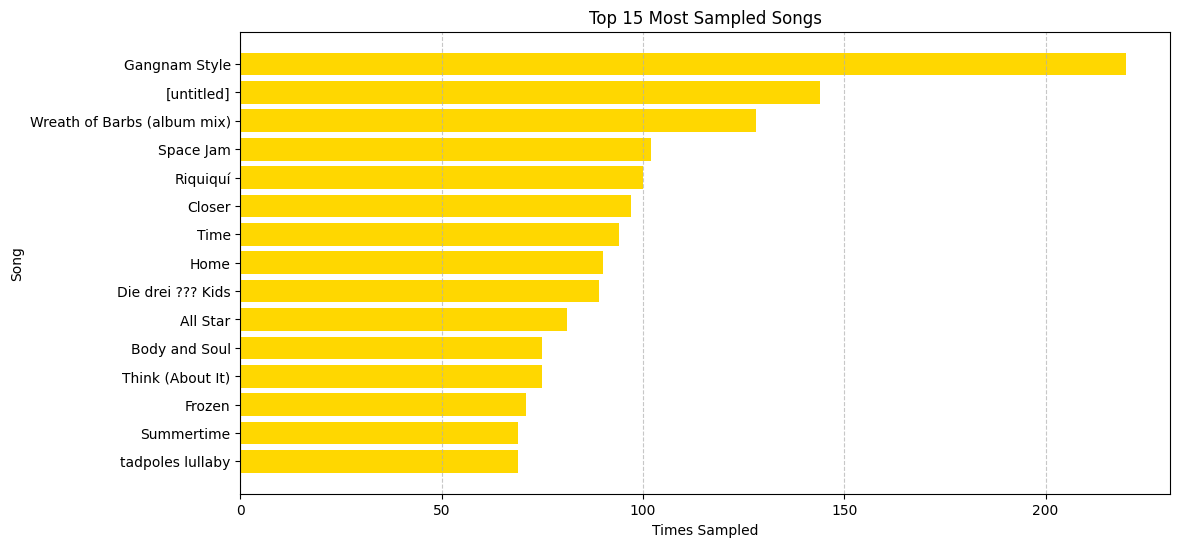

In [23]:
# Compute most sampled songs
sampled_songs = {
    node: G.in_degree(node) for node, data in G.nodes(data=True) if data["node_type"] == "recording"
}

top_sampled_songs = sorted(sampled_songs.items(), key=lambda x: x[1], reverse=True)[:15]
songs, counts = zip(*top_sampled_songs)

# --- Plot Bar Chart ---
plt.figure(figsize=(12, 6))
plt.barh(songs[::-1], counts[::-1], color="gold")

plt.xlabel("Times Sampled")
plt.ylabel("Song")
plt.title("Top 15 Most Sampled Songs")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()


## Artist sub graph

In [24]:
def search_artist_in_arango(artist_name):
    """Searches ArangoDB for an artist with a similar name and returns the first match."""
    query = f"""
    FOR doc IN MusicDiscovery_node
        FILTER LOWER(doc.name) LIKE LOWER("%{artist_name}%")
        RETURN doc.name
    """
    results = list(db.aql.execute(query))
    
    if results:
        selected_artist = results[0]  # Choose the first result
        return selected_artist
    else:
        print(f"⚠️ {artist_name} not found in ArangoDB.")
        return None

# Example Usage
first_artist = search_artist_in_arango("Beethoven")
print(f"🎵 Selected Artist: {first_artist}")


🎵 Selected Artist: Ludwig van Beethoven


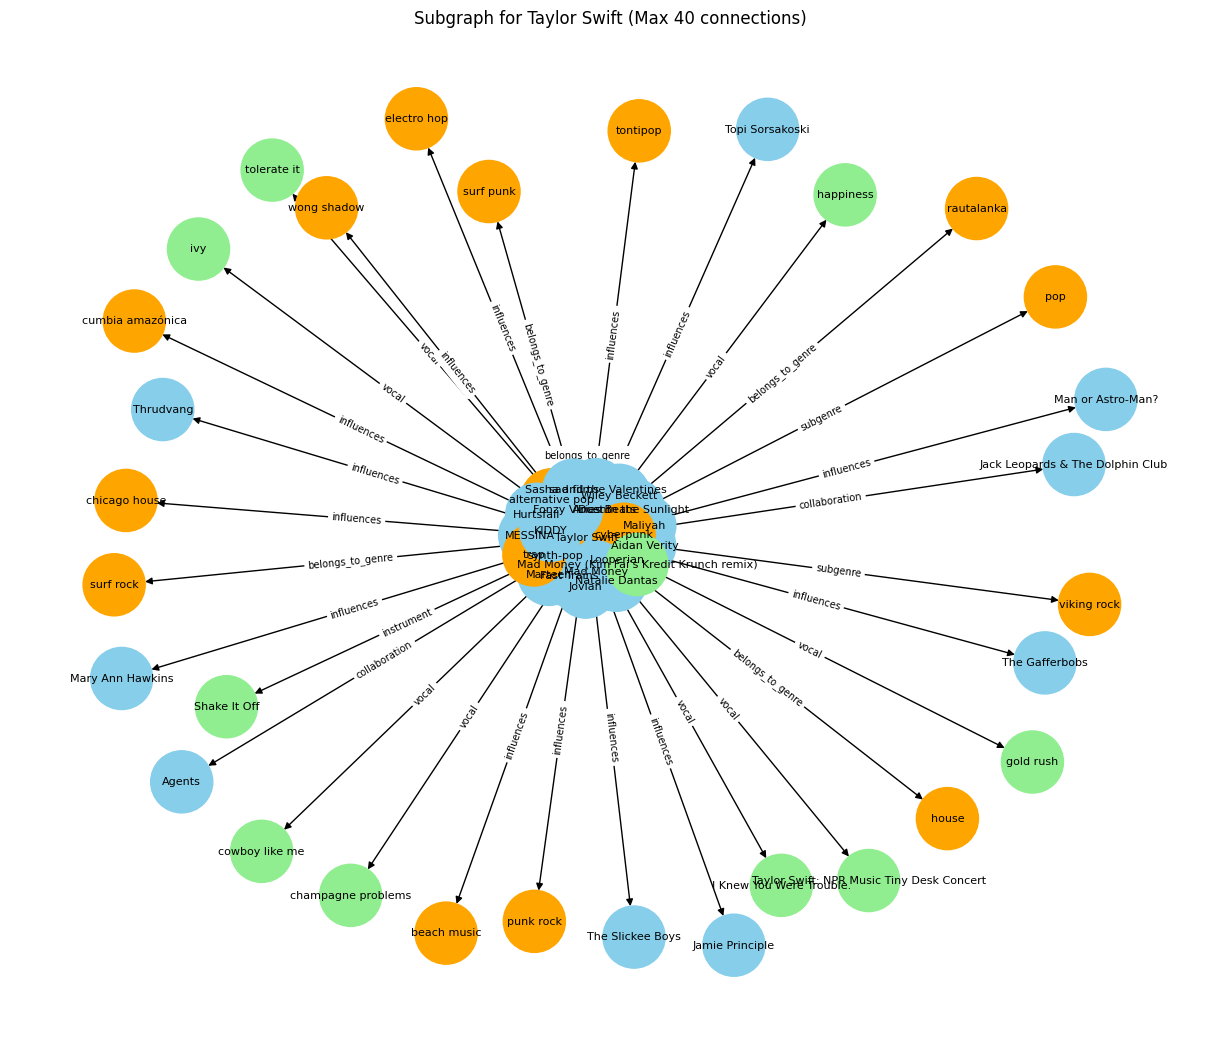

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

def fetch_artist_subgraph_from_arango(artist_name, depth=2, limit=10):
    """
    Fetches the artist's subgraph from ArangoDB, including both outgoing and incoming relationships.
    
    Parameters:
        artist_name (str): The name of the artist.
        depth (int): The number of layers to traverse in the graph.
        limit (int): The maximum number of outgoing and incoming edges to fetch.
    
    Returns:
        dict: A dictionary containing nodes and edges related to the artist.
    """

    query = f"""
    LET artist_doc = FIRST(
        FOR a IN MusicDiscovery_node
        FILTER CONTAINS(LOWER(a.name), LOWER("{artist_name}")) && a.node_type == "artist"
        RETURN a
    )

    LET outgoing_edges = UNIQUE(
        FOR v, e IN 1..{depth} OUTBOUND artist_doc._id GRAPH "MusicDiscovery"
        LIMIT {limit}
        RETURN {{
            "name": v.name,
            "type": v.node_type,
            "neighbor": v._id,
            "relationship": e.relationship,
            "direction": "outgoing"
        }}
    )

    LET incoming_edges = UNIQUE(
        FOR v, e IN 1..{depth} INBOUND artist_doc._id GRAPH "MusicDiscovery"
        LIMIT {limit}
        RETURN {{
            "name": v.name,
            "type": v.node_type,
            "neighbor": v._id,
            "relationship": e.relationship,
            "direction": "incoming"
        }}
    )

    RETURN {{
        "artist": artist_doc.name,
        "outgoing": outgoing_edges,
        "incoming": incoming_edges
    }}
    """
    
    result = list(db.aql.execute(query))

    if not result or result[0] is None:
        print(f"⚠️ No subgraph data found for {artist_name} in ArangoDB.")
        return None

    return result[0]


def plot_artist_subgraph(artist_name, depth=2, limit=10):
    """
    Plots the subgraph of a given artist, fetching data from ArangoDB if missing.
    
    Parameters:
        artist_name (str): The name of the artist.
        depth (int): The number of connection layers to visualize.
        limit (int): The maximum number of outgoing and incoming edges to fetch.
    """

    # 🔎 Step 1: Search for the artist in ArangoDB
    subgraph_data = fetch_artist_subgraph_from_arango(artist_name, depth, limit)

    if not subgraph_data:
        return

    artist_name = subgraph_data["artist"]
    outgoing_edges = subgraph_data["outgoing"]
    incoming_edges = subgraph_data["incoming"]

    # Initialize a directed graph
    tempG = nx.DiGraph()

    # Add artist node
    tempG.add_node(artist_name, node_type="artist")

    # Process outgoing edges
    for record in outgoing_edges:
        neighbor = record["name"]
        relationship = record["relationship"]
        node_type = record["type"]
        
        tempG.add_node(neighbor, node_type=node_type)
        tempG.add_edge(artist_name, neighbor, relationship=relationship)

    # Process incoming edges
    for record in incoming_edges:
        neighbor = record["name"]
        relationship = record["relationship"]
        node_type = record["type"]

        tempG.add_node(neighbor, node_type=node_type)
        tempG.add_edge(neighbor, artist_name, relationship=relationship)

    # ✅ Step 4: Set colors based on node type
    node_colors = {
        "artist": "skyblue",
        "recording": "lightgreen",
        "genre": "orange",
    }
    node_color_map = [node_colors.get(tempG.nodes[n].get("node_type", "unknown"), "gray") for n in tempG.nodes]

    # ✅ Step 5: Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(tempG, seed=42)
    nx.draw(tempG, pos, with_labels=True, node_color=node_color_map, edge_color="black", node_size=2000, font_size=8)

    # Label edges with relationship types
    edge_labels = {(u, v): d["relationship"] for u, v, d in tempG.edges(data=True)}
    nx.draw_networkx_edge_labels(tempG, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Subgraph for {artist_name} (Max {limit} connections)")
    plt.show()

# 🎵 Example Usage:
plot_artist_subgraph("Taylor Swift", depth=100, limit=40)




## 💬 6. Interactive Search: Find an Artist’s Influence

In [27]:
import psycopg2
import pandas as pd
import networkx as nx

# --- Expand Graph by Adding Artist ---
def expand_artist(artist_name, conn):
    """Expands the graph by adding an artist and their relationships if they are not in the graph."""
    print(f"🔍 Searching for {artist_name} in the database...")

    query_artist_id = """
    SELECT id FROM musicbrainz.artist WHERE name = %s LIMIT 1;
    """
    df_artist = pd.read_sql_query(query_artist_id, conn, params=[artist_name])

    if df_artist.empty:
        print(f"⚠️ Artist '{artist_name}' not found in MusicBrainz database.")
        return

    artist_id = int(df_artist.iloc[0]["id"])  # 🔹 Convert to Python int

    # --- Fetch artist-genre relationships ---
    query_artist_genres = """
    SELECT g.name AS genre_name
    FROM musicbrainz.l_artist_genre lag
    JOIN musicbrainz.genre g ON lag.entity1 = g.id
    WHERE lag.entity0 = %s;
    """
    df_artist_genres = pd.read_sql_query(query_artist_genres, conn, params=[artist_id])
    print(df_artist_genres)

    # --- Fetch artist-recording relationships ---
    query_artist_recordings = """
    SELECT r.name AS recording_name, lt.name AS relationship_type
    FROM musicbrainz.l_artist_recording lar
    JOIN musicbrainz.recording r ON lar.entity1 = r.id
    JOIN musicbrainz.link l ON lar.link = l.id
    JOIN musicbrainz.link_type lt ON l.link_type = lt.id
    WHERE lar.entity0 = %s
    AND lt.name IN ('performer', 'producer', 'remixer', 'DJ-mix', 'sound');
    """
    df_artist_recordings = pd.read_sql_query(query_artist_recordings, conn, params=[artist_id])
    df_artist_recordings
    
    # --- Fetch artist collaborations ---
    query_artist_collaborations = """
    SELECT a2.name AS collaborator
    FROM musicbrainz.l_artist_artist laa
    JOIN musicbrainz.artist a2 ON laa.entity1 = a2.id
    JOIN musicbrainz.link l ON laa.link = l.id
    JOIN musicbrainz.link_type lt ON l.link_type = lt.id
    WHERE laa.entity0 = %s
    AND lt.name = 'collaboration';
    """
    df_artist_collaborations = pd.read_sql_query(query_artist_collaborations, conn, params=[artist_id])

    # --- Add artist node ---
    if artist_name not in G:
        G.add_node(artist_name, node_type="artist")

    # --- Add genre edges ---
    for _, row in df_artist_genres.iterrows():
        genre = row["genre_name"]
        if genre not in G:
            G.add_node(genre, node_type="genre")
        G.add_edge(artist_name, genre, relationship="belongs_to_genre")
        G.add_edge(genre, artist_name, relationship="influences")

    # --- Add recording edges ---
    for _, row in df_artist_recordings.iterrows():
        recording, rel_type = row["recording_name"], row["relationship_type"]
        if recording not in G:
            G.add_node(recording, node_type="recording")
        G.add_edge(artist_name, recording, relationship=rel_type)

    # --- Add collaboration edges (only if collaborator exists) ---
    for _, row in df_artist_collaborations.iterrows():
        collaborator = row["collaborator"]
        if collaborator in G:
            G.add_edge(artist_name, collaborator, relationship="collaboration")
            G.add_edge(collaborator, artist_name, relationship="collaboration")

    print(f"✅ {artist_name} added to the graph with {len(df_artist_genres)} genres, {len(df_artist_recordings)} recordings, and {len(df_artist_collaborations)} collaborations.")

# --- Get Artist Information (with Dynamic Expansion) ---
def get_artist_info_from_arango(artist_name, limit=10):
    """
    Retrieves an artist's influence stats from ArangoDB.

    Parameters:
        artist_name (str): The name of the artist.
        limit (int): The maximum number of results for each category.
    """
    
    query = f"""
    LET artist_doc = FIRST(
        FOR a IN MusicDiscovery_node
        FILTER CONTAINS(LOWER(a.name), LOWER("{artist_name}")) && a.node_type == "artist"
        RETURN a._id
    )

    LET collaborations = (
        FOR v, e IN 1..1 OUTBOUND artist_doc GRAPH "MusicDiscovery"
        FILTER v.node_type == "artist"
        LIMIT {limit}
        RETURN v.name
    )

    LET influenced_genres = (
        FOR v, e IN 1..1 OUTBOUND artist_doc GRAPH "MusicDiscovery"
        FILTER v.node_type == "genre"
        LIMIT {limit}
        RETURN v.name
    )

    LET works_created = (
        FOR v, e IN 1..1 OUTBOUND artist_doc GRAPH "MusicDiscovery"
        FILTER v.node_type == "recording"
        LIMIT {limit}
        RETURN v.name
    )

    LET sampled_songs = (
        FOR v, e IN 1..1 OUTBOUND artist_doc GRAPH "MusicDiscovery"
        FILTER e.relationship == "sample"
        LIMIT {limit}
        RETURN v.name
    )

    RETURN {{
        "artist": artist_doc,
        "collaborations": collaborations,
        "influenced_genres": influenced_genres,
        "works_created": works_created,
        "sampled_songs": sampled_songs
    }}
    """

    results = list(db.aql.execute(query))

    if not results or results[0] is None:
        print(f"⚠️ No data found for {artist_name} in ArangoDB.")
        return None

    data = results[0]

    # ✅ Print Artist Influence Stats
    print(f"\n🎤 {artist_name} Influence Stats:")
    print(f"- Number of Collaborations: {len(data['collaborations'])}")
    print(f"- Collaborating Artists: {', '.join(data['collaborations']) if data['collaborations'] else 'None'}")
    print(f"- Influenced Genres: {', '.join(data['influenced_genres']) if data['influenced_genres'] else 'None'}")
    print(f"- Works Created: {', '.join(data['works_created']) if data['works_created'] else 'None'}")
    print(f"- Sampled Songs: {', '.join(data['sampled_songs']) if data['sampled_songs'] else 'None'}")

# 🎵 Example Usage
get_artist_info_from_arango("Travis Scott", limit=10)







🎤 Travis Scott Influence Stats:
- Number of Collaborations: 9
- Collaborating Artists: The Graduates, THE SCOTTS, JACKBOYS, HUNCHO JACK, Christopher Nolan, Mike Dean, WondaGurl, Ludwig Göransson, Travis Scott
- Influenced Genres: None
- Works Created: None
- Sampled Songs: None


## 🎵 Hip Hop Genre Stats:  🎵

In [ ]:
def get_genre_info(genre_name):
    """
    Retrieve statistics about a genre, including the number of associated artists
    and a sample of artists belonging to that genre.
    """
    if genre_name in G and G.nodes[genre_name].get("node_type") == "genre":
        # Get all connected nodes (artists) that belong to this genre
        artists = [n for n in G.neighbors(genre_name) if G.nodes[n]['node_type'] == 'artist']
        
        print(f"\n🎵 **{genre_name} Genre Stats:** 🎵")
        print(f"- Total Artists: {len(artists)}")
        
        # Show a sample of up to 10 artists
        if artists:
            print(f"- Sample Artists: {', '.join(artists[:10])} {'...' if len(artists) > 10 else ''}")
        else:
            print("⚠️ No artists found for this genre.")
        
        # Find connections from the genre to other nodes (e.g., influence relationships)
        influence_edges = [(genre_name, n, G[genre_name][n].get('relationship')) for n in G.neighbors(genre_name) if genre_name in G and n in G]
        if influence_edges:
            print(f"- Connections: {', '.join(f'{src} ➡️ {tgt} ({rel})' for src, tgt, rel in influence_edges[:5])} {'...' if len(influence_edges) > 5 else ''}")
        else:
            print("⚠️ No direct influence connections found for this genre.")
    
    else:
        print(f"⚠️ Genre '{genre_name}' not found in the graph.")

# Example Usage
get_genre_info("pop")



🎵 **pop Genre Stats:** 🎵
- Total Artists: 4972
- Sample Artists: New Edition, The Kelly Family, Modern Talking, Rick Astley, Freddy Quinn, Blondie, Bay City Rollers, Ella Baila Sola, Danny Wilson, Joe Fagin ...
- Connections: pop ➡️ New Edition (influences), pop ➡️ The Kelly Family (influences), pop ➡️ Modern Talking (influences), pop ➡️ Rick Astley (influences), pop ➡️ Freddy Quinn (influences) ...




> Entering new AgentExecutor chain...
Thought: I need to analyze this query to find the subgenres of hip hop.
Action: text_to_aql_to_text
Action Input: What are the subgenres of hip hop?AQL Execution Error: [HTTP 400][ERR 1501] syntax error, unexpected identifier near '``aql
FOR genre IN Genres
  FILT...' at position 1:2I need to try a different approach to find the subgenres of hip hop. I will use another tool to analyze the relationships in the graph database.
Action: text_to_nx_algorithm_to_text
Action Input: Find subgenres of hip hop🔹 Generated Code:
import networkx as nx

# Assuming G_adb is already defined and populated with nodes and edges

# Filter nodes to get only subgenres of hip hop
subgenres_of_hip_hop = [n for n, attr in G_adb.nodes(data=True) if attr.get('type') == 'genre' and 'hip hop' in n.lower()]

# Initialize a dictionary to store relationships
subgenre_relationships = {}

# Iterate over each subgenre to find related artists and collaborations
for subgenre in subg

✅ Genre Subgraph Created with 1844 nodes and 3196 edges


/Users/uthmanoali98/Desktop/musicbrainz_data/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


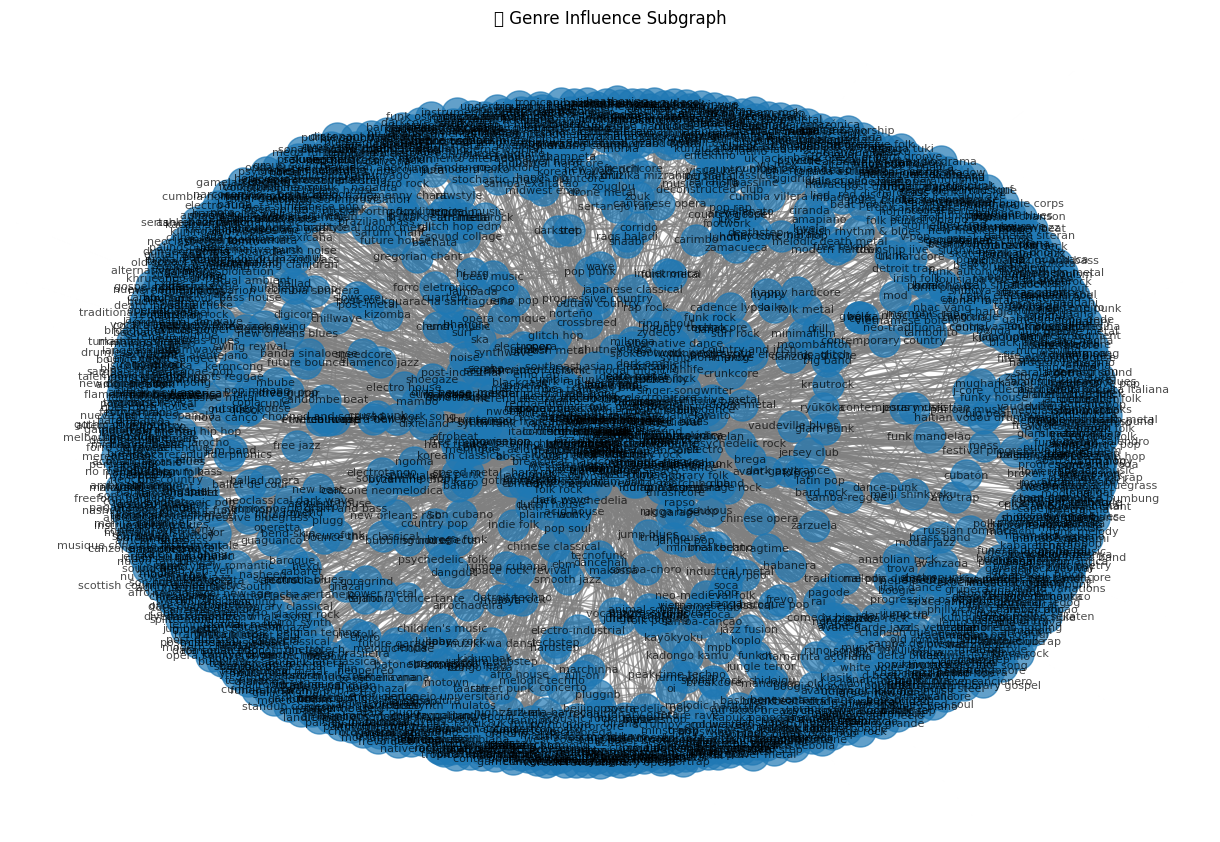

In [30]:
import matplotlib.pyplot as plt

# --- Create a Subgraph with Only Genre Nodes ---
genre_nodes = [node for node, data in G.nodes(data=True) if data["node_type"] == "genre"]
G_genre = G.subgraph(genre_nodes).copy()

print(f"✅ Genre Subgraph Created with {G_genre.number_of_nodes()} nodes and {G_genre.number_of_edges()} edges")

# --- Visualize the Genre Influence Subgraph ---
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_genre, seed=42)  # Positioning for better visualization
nx.draw(G_genre, pos, with_labels=True, node_size=500, font_size=8, edge_color="gray", alpha=0.7)

plt.title("🎶 Genre Influence Subgraph")
plt.show()


In [31]:
# --- Compute Degree Centrality (Most Influential Genre) ---
genre_influence = {node: G_genre.degree(node) for node in G_genre.nodes()}
most_influential_genre = max(genre_influence, key=genre_influence.get)

print(f"🏆 Most Influential Genre: {most_influential_genre} with {genre_influence[most_influential_genre]} connections.")


🏆 Most Influential Genre: pop with 97 connections.


# AI Chatbot

In [19]:
pip install typing_extensions==4.7.1 --upgrade


  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openai 1.65.4 requires typing-extensions<5,>=4.11, but you have typing-extensions 4.7.1 which is incompatible.
pydantic 2.10.6 requires typing-extensions>=4.12.2, but you have typing-extensions 4.7.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
from collections import Counter
import os
import re
import networkx as nx
import threading
import io
import queue
import time
from arango import ArangoClient
from langchain.tools import tool
from langchain.chat_models import ChatOpenAI
from langchain.agents import create_react_agent
from langchain_community.graphs.arangodb_graph import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor
import gradio as gr
import json
from PIL import Image

# --- Set up ArangoDB Connection ---
os.environ["DATABASE_HOST"] = "https://b2f7971c2b5a.arangodb.cloud:8529"
os.environ["DATABASE_USERNAME"] = "root"
os.environ["DATABASE_PASSWORD"] = "ed4Ok1F6zqmwaMdgCHLw"
os.environ["DATABASE_NAME"] = "MusicBrainzData"

# Initialize ArangoDB Client
client = ArangoClient(hosts=os.environ["DATABASE_HOST"])
db = client.db(os.environ["DATABASE_NAME"], username=os.environ["DATABASE_USERNAME"], password=os.environ["DATABASE_PASSWORD"])
arango_graph = ArangoGraph(db)

# --- Create NetworkX Graph from ArangoDB ---
# This should be done only once at startup instead of for each query
G_adb = nx.DiGraph()

# Load nodes and edges from ArangoDB (add sample data if not available)
try:
    # Load artist nodes
    artist_query = "FOR a IN MusicDiscovery_node FILTER a.node_type == 'artist' RETURN a"
    artists = list(db.aql.execute(artist_query))
    for artist in artists:
        G_adb.add_node(artist['name'], node_type='artist', **artist)
    
    # Load genre nodes
    genre_query = "FOR g IN MusicDiscovery_node FILTER g.node_type == 'genre' RETURN g"
    genres = list(db.aql.execute(genre_query))
    for genre in genres:
        G_adb.add_node(genre['name'], node_type='genre', **genre)
    
    # Load relationships
    relationship_query = "FOR e IN MusicDiscovery_edge RETURN e"
    relationships = list(db.aql.execute(relationship_query))
    for rel in relationships:
        G_adb.add_edge(rel['_from'], rel['_to'], relationship=rel['relationship'], **rel)
        
except Exception as e:
    print(f"Unable to load graph data: {e}")
    # Add some sample data so the code can still run
    sample_artists = ["Beyoncé", "Jay-Z", "Taylor Swift", "Drake", "Adele"]
    sample_genres = ["Pop", "Hip-Hop", "R&B", "Rock", "Electronic"]
    
    # Add nodes
    for artist in sample_artists:
        G_adb.add_node(artist, node_type="artist")
    for genre in sample_genres:
        G_adb.add_node(genre, node_type="genre")
    
    # Add some edges
    G_adb.add_edge("Beyoncé", "R&B", relationship="performs")
    G_adb.add_edge("Beyoncé", "Pop", relationship="performs")
    G_adb.add_edge("Jay-Z", "Hip-Hop", relationship="performs")
    G_adb.add_edge("Jay-Z", "Beyoncé", relationship="collaborates_with")
    G_adb.add_edge("Taylor Swift", "Pop", relationship="performs")
    G_adb.add_edge("Drake", "Hip-Hop", relationship="performs")
    G_adb.add_edge("Drake", "R&B", relationship="performs")
    G_adb.add_edge("Adele", "Pop", relationship="performs")

# --- Set up LLM ---
llm = ChatOpenAI(temperature=0.2, model_name="gpt-4o")

# --- Fetch List of Artists for Dropdown ---
def get_all_artists():
    artist_query = "FOR a IN MusicDiscovery_node FILTER a.node_type == 'artist' RETURN a"
    artists = list(db.aql.execute(artist_query))
    
    print(f"✅ Loaded {len(artists)} artists from ArangoDB")

    # for artist in artists:
    #     G_adb.add_node(artist['name'], node_type='artist', **artist)

    # Debug: Print first few artist names
    if artists:
        print("Sample artists:", [a["name"] for a in artists[:5]])
    else:
        print("⚠️ No artists found in ArangoDB!")

# --- Updated Pathfinding with Fuzzy Matching ---
def find_artist_path(artist_a, artist_b, max_depth=5):
    """
    Finds the shortest path between two artists in the graph.
    If an exact match isn't found, it attempts fuzzy matching.
    """
    artist_a = fuzzy_search_entity(artist_a) or artist_a
    artist_b = fuzzy_search_entity(artist_b) or artist_b

    if artist_a not in G_adb or artist_b not in G_adb:
        return None  # If either artist is missing, return None
    
    try:
        path = nx.shortest_path(G_adb, source=artist_a, target=artist_b)
        return path if len(path) <= max_depth else None  # Limit path depth
    except nx.NetworkXNoPath:
        return None  # No path found

def artist_evolution_query(artist_a, artist_b):
    """
    Generates an evolution story of Artist A → Artist B, ensuring genre evolution is discussed.
    """
    yield "⏳ Analyzing artist connections..."

    path = find_artist_path(artist_a, artist_b)

    if path:
        formatted_path = " ➝ ".join(path)
        prompt = f"""
        🎶 Artist Evolution Narrative 🎶

        We have found a historical path of influence:
        {formatted_path}

        Please generate a **detailed historical explanation** of how {artist_a} influenced {artist_b},
        including **key collaborations, industry shifts, and genre evolution**.
        Make this engaging, informative, and historically accurate.
        """
    else:
        prompt = f"""
        🎶 Artist Evolution Narrative 🎶

        No direct path was found between {artist_a} and {artist_b}.

        Please **create a historically plausible connection** between these artists,
        considering their **genres, eras, and industry trends**.
        Discuss how **genre evolution** played a role in their music.
        """

    response = llm.invoke(prompt).content
    yield response
    

# --- Function to Fetch Artist Graph ---
def fetch_artist_subgraph_from_arango(artist_name, depth=2, limit=10):
    """
    Fetches the artist's influence graph from ArangoDB, including relationships with genres and other artists.
    """
    query = f"""
    LET artist_doc = FIRST(
        FOR a IN MusicDiscovery_node
        FILTER CONTAINS(LOWER(a.name), LOWER("{artist_name}")) && a.node_type == "artist"
        RETURN a
    )

    LET outgoing_edges = UNIQUE(
        FOR v, e IN 1..{depth} OUTBOUND artist_doc._id GRAPH "MusicDiscovery"
        LIMIT {limit}
        RETURN {{
            "name": v.name,
            "type": v.node_type,
            "neighbor": v._id,
            "relationship": e.relationship
        }}
    )

    LET incoming_edges = UNIQUE(
        FOR v, e IN 1..{depth} INBOUND artist_doc._id GRAPH "MusicDiscovery"
        LIMIT {limit}
        RETURN {{
            "name": v.name,
            "type": v.node_type,
            "neighbor": v._id,
            "relationship": e.relationship
        }}
    )

    RETURN {{
        "artist": artist_doc.name,
        "outgoing": outgoing_edges,
        "incoming": incoming_edges
    }}
    """
    
    result = list(db.aql.execute(query))

    if not result or result[0] is None:
        return None

    return result[0]

# --- Function to Plot Artist Influence Graph ---
def plot_artist_graph(artist_name, depth=2, limit=10):
    """
    Visualizes the artist's influence network and returns an image for Gradio.
    """
    subgraph_data = fetch_artist_subgraph_from_arango(artist_name, depth, limit)

    if not subgraph_data:
        return f"⚠️ No subgraph data found for '{artist_name}'.", None, None

    artist_name = subgraph_data["artist"]
    outgoing_edges = subgraph_data["outgoing"]
    incoming_edges = subgraph_data["incoming"]

    # Initialize directed graph
    G = nx.DiGraph()

    # Add artist node
    G.add_node(artist_name, node_type="artist")

    # Process outgoing edges
    for record in outgoing_edges:
        neighbor = record["name"]
        relationship = record["relationship"]
        node_type = record["type"]
        
        G.add_node(neighbor, node_type=node_type)
        G.add_edge(artist_name, neighbor, relationship=relationship)

    # Process incoming edges
    for record in incoming_edges:
        neighbor = record["name"]
        relationship = record["relationship"]
        node_type = record["type"]

        G.add_node(neighbor, node_type=node_type)
        G.add_edge(neighbor, artist_name, relationship=relationship)

    # Set colors based on node type
    node_colors = {
        "artist": "skyblue",
        "recording": "lightgreen",
        "genre": "orange",
    }
    node_color_map = [node_colors.get(G.nodes[n].get("node_type", "unknown"), "gray") for n in G.nodes]

    # Draw graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_color_map, edge_color="black", node_size=2000, font_size=8)

    # Label edges with relationships
    edge_labels = {(u, v): d["relationship"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Influence Graph for {artist_name}")

    # Save plot to a BytesIO object
    # Convert the plot to a PIL Image
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format="PNG", bbox_inches="tight")
    plt.close()  # Close the figure to free memory
    img_buffer.seek(0)

    image = Image.open(img_buffer)

    # Get related artists
    related_artists = [n for n, attr in G.nodes(data=True) if attr.get("node_type") == "artist" and n != artist_name]

    return f"✅ Influence graph for {artist_name} generated.", related_artists, image
# --- Function to Get AI-based Artist Recommendations ---
def get_ai_artist_recommendations(artist_name):
    """
    Uses the AI model to suggest similar artists if the graph doesn't return connected artists.
    """
    prompt = f"""
    The user is exploring music influences and is interested in artists similar to "{artist_name}".
    Please suggest 3-5 similar artists who share musical influences, genres, or styles.
    """
    return llm.invoke(prompt).content.strip()

# --- Gradio UI Function for Artist Graph ---
def query_artist_graph(artist_name, depth=2, limit=10):
    """
    Fetches the artist's influence graph and displays it with artist recommendations.
    """
    yield "⏳ Fetching artist graph...", None  # Always return both expected outputs

    graph_status, related_artists, graph_img = plot_artist_graph(artist_name, depth, limit)

    if not related_artists:
        yield f"{graph_status}\n\n🔍 No connected artists found in the graph. Fetching AI recommendations...", graph_img
        
        recommendations = get_ai_artist_recommendations(artist_name)
        
        yield f"🎶 **AI Suggested Artists:**\n{recommendations}", graph_img  # Ensure an image is returned
    else:
        yield f"{graph_status}\n\n🎵 **You may also like:** {', '.join(related_artists)}", graph_img


# --- Fuzzy Search Function (ArangoDB `NGRAM_MATCH`) ---
def fuzzy_search_entity(entity_name):
    """Finds the closest matching entity (artist/genre) using ArangoDB's `NGRAM_MATCH` for fuzzy search."""
    try:
        query = f"""
        FOR doc IN MusicDiscovery_node
            FILTER NGRAM_MATCH(LOWER(doc.name), LOWER("{entity_name}"), 0.6)
            SORT BM25(doc) DESC
            LIMIT 1
            RETURN doc.name
        """
        results = list(db.aql.execute(query))
        return results[0] if results else None
    except Exception as e:
        print(f"Fuzzy search error: {e}")
        # Fall back to simple string matching in our NetworkX graph
        best_match = None
        best_score = 0
        for node in G_adb.nodes():
            if isinstance(node, str):
                score = len(set(node.lower()) & set(entity_name.lower())) / max(len(node), len(entity_name))
                if score > best_score and score > 0.5:
                    best_score = score
                    best_match = node
        return best_match

# --- Genre Subgraph Functions ---
def fetch_genre_subgraph_from_arango(genre_name, depth=2, limit=15):
    """
    Fetches the subgraph of a given genre from ArangoDB with a limit on results.
    """
    try:
        query = """
        LET genre_doc = FIRST(
            FOR g IN MusicDiscovery_node
            FILTER CONTAINS(LOWER(g.name), LOWER(@genre_name)) && g.node_type == "genre"
            RETURN g
        )

        LET outgoing_edges = UNIQUE(
            FOR v, e IN 1..@depth OUTBOUND genre_doc._id GRAPH "MusicDiscovery"
            LIMIT @limit
            RETURN {
                "connected_node": v.name,
                "node_type": v.node_type,
                "relationship": e.relationship,
                "direction": "influences"
            }
        )

        LET incoming_edges = UNIQUE(
            FOR v, e IN 1..@depth INBOUND genre_doc._id GRAPH "MusicDiscovery"
            LIMIT @limit
            RETURN {
                "connected_node": v.name,
                "node_type": v.node_type,
                "relationship": e.relationship,
                "direction": "influenced_by"
            }
        )

        RETURN { 
            "genre": genre_doc.name, 
            "outgoing": outgoing_edges, 
            "incoming": incoming_edges
        }
        """

        bind_vars = {
            "genre_name": genre_name,
            "depth": depth,
            "limit": limit
        }

        results = list(db.aql.execute(query, bind_vars=bind_vars))

        if not results or not results[0]:
            return {"error": f"No subgraph data found for {genre_name} in ArangoDB."}

        return results[0]  # Extract the single returned dictionary
        
    except Exception as e:
        print(f"Error fetching genre subgraph: {e}")
        # Fall back to NetworkX if ArangoDB query fails
        return get_genre_subgraph_from_networkx(genre_name, depth, limit)

def get_genre_subgraph_from_networkx(genre_name, depth=2, limit=15):
    """
    Fallback function to get genre subgraph from NetworkX if ArangoDB query fails.
    """
    # Find the closest matching genre in our graph
    genre_nodes = [n for n, attr in G_adb.nodes(data=True) 
                  if attr.get('node_type') == 'genre' and 
                  genre_name.lower() in n.lower()]
    
    if not genre_nodes:
        return {"error": f"Genre '{genre_name}' not found in the graph."}
    
    # Use the first match
    genre = genre_nodes[0]
    
    # Extract subgraph data
    outgoing = []
    incoming = []
    
    # Get outgoing edges (genres influenced by this genre)
    for path in nx.all_simple_paths(G_adb, source=genre, cutoff=depth):
        if len(outgoing) >= limit:
            break
        for i in range(len(path)-1):
            if G_adb.has_edge(path[i], path[i+1]):
                relationship = G_adb[path[i]][path[i+1]].get('relationship', 'connected_to')
                node_type = G_adb.nodes[path[i+1]].get('node_type', 'unknown')
                outgoing.append({
                    "connected_node": path[i+1],
                    "node_type": node_type,
                    "relationship": relationship,
                    "direction": "influences"
                })
    
    # Get incoming edges (genres that influenced this genre)
    for node in G_adb.nodes():
        if len(incoming) >= limit:
            break
        for path in nx.all_simple_paths(G_adb, source=node, target=genre, cutoff=depth):
            if len(path) > 1:
                i = len(path) - 2  # Second-to-last node
                relationship = G_adb[path[i]][path[i+1]].get('relationship', 'connected_to')
                node_type = G_adb.nodes[path[i]].get('node_type', 'unknown')
                incoming.append({
                    "connected_node": path[i],
                    "node_type": node_type,
                    "relationship": relationship,
                    "direction": "influenced_by"
                })
    
    return {
        "genre": genre,
        "outgoing": outgoing,
        "incoming": incoming
    }

def get_genre_statistics(genre_name):
    """
    Get statistical information about a genre from the graph.
    """
    # Try to find the genre in the graph
    genre_nodes = [n for n, attr in G_adb.nodes(data=True) 
                  if attr.get('node_type') == 'genre' and 
                  genre_name.lower() in n.lower()]
    
    if not genre_nodes:
        return {"error": f"Genre '{genre_name}' not found in the graph."}
    
    # Use the first match
    genre = genre_nodes[0]
    
    # Initialize stats dictionary
    stats = {
        "genre_name": genre,
        "total_artists": 0,
        "sample_artists": [],
        "influenced_genres": [],
        "influenced_by_genres": [],
        "top_relationships": {}
    }
    
    # Get artists associated with this genre
    artists = [n for n, attr in G_adb.nodes(data=True) 
              if attr.get('node_type') == 'artist' and 
              G_adb.has_edge(n, genre)]
    
    stats["total_artists"] = len(artists)
    stats["sample_artists"] = artists[:10]
    
    # Get genres influenced by this genre
    influenced_genres = [n for n, attr in G_adb.nodes(data=True) 
                        if attr.get('node_type') == 'genre' and 
                        G_adb.has_edge(genre, n)]
    
    stats["influenced_genres"] = influenced_genres[:10]
    
    # Get genres that influenced this genre
    influenced_by_genres = [n for n, attr in G_adb.nodes(data=True) 
                           if attr.get('node_type') == 'genre' and 
                           G_adb.has_edge(n, genre)]
    
    stats["influenced_by_genres"] = influenced_by_genres[:10]
    
    # Count relationships
    relationships = [G_adb[u][v].get('relationship', 'connected_to') 
                    for u, v, _ in G_adb.edges(data=True) 
                    if u == genre or v == genre]
    
    stats["top_relationships"] = dict(Counter(relationships).most_common(5))
    
    return stats

# --- Tool 1: Convert Text to AQL to Text ---
@tool
def text_to_aql_to_text(query: str):
    """Converts a natural language query into an optimized AQL query and executes it with fuzzy search."""
    # Check for the closest entity match
    closest_match = fuzzy_search_entity(query)
    
    if closest_match:
        print(f"🔍 Fuzzy Search Matched: {closest_match}")
        query = query.replace(query, closest_match)

    # Construct an optimized AQL prompt
    aql_prompt = f"""
    Convert the following natural language question into a structured AQL query:

    User Query: {query}

    - If the query involves an artist or genre, use fuzzy search to find the closest match.
    - Return only the AQL query itself (no explanations).
    
    Generated AQL Query:
    """
    
    # Generate AQL query using LLM
    aql_query = llm.invoke(aql_prompt).content.strip()

    try:
        results = list(db.aql.execute(aql_query))
        
        if not results:
            return "No relevant data found in ArangoDB."
            
        # Format results for readability
        formatted_results = []
        for item in results:
            if isinstance(item, dict):
                formatted_results.append(item)
            else:
                formatted_results.append({"result": item})
                
        return json.dumps(formatted_results, indent=2)
    
    except Exception as e:
        return f"AQL Execution Error: {e}"

# --- Tool 2: Convert Text to NetworkX Algorithms to Text ---
@tool
def text_to_nx_algorithm_to_text(query: str):
    """Executes a NetworkX algorithm with fuzzy search to find and analyze relationships."""
    
    # Extract unique node and edge types dynamically
    node_types = set(nx.get_node_attributes(G_adb, "node_type").values())
    edge_types = set(nx.get_edge_attributes(G_adb, "relationship").values())
    
    # Find closest entity match
    closest_match = fuzzy_search_entity(query)
    
    if closest_match:
        print(f"🔍 Fuzzy Search Matched: {closest_match}")
        entity_name = closest_match
    else:
        # Extract a potential entity name from the query
        entity_name = re.search(r"(analyze|find|how|what).*?([\w\s']+)'?s?", query.lower())
        entity_name = entity_name.group(2).strip() if entity_name else ""
    
    # Simplified NetworkX code generation
    text_to_nx_prompt = f"""
    Write simple NetworkX code to analyze musical relationships for "{entity_name}" in a graph G_adb.
    
    Available node types: {', '.join(node_types) if node_types else 'artist, genre'}
    Available relationship types: {', '.join(edge_types) if edge_types else 'performs, collaborates_with'}
    
    The code should:
    1. Be simple and efficient (no complex algorithms)
    2. Run in under 5 seconds
    3. Assign the final result to FINAL_RESULT
    4. Return only the Python code
    """
    
    # Generate NetworkX Python code using LLM
    generated_code = llm.invoke(text_to_nx_prompt).content.strip()
    
    # Clean up the code
    cleaned_code = re.sub(r"^```python\n|```$", "", generated_code, flags=re.MULTILINE).strip()
    
    print("🔹 Generated Code:")
    print(cleaned_code)
    
    # Execute the generated code with safeguards
    global_vars = {"G_adb": G_adb, "nx": nx, "entity_name": entity_name}
    local_vars = {}
    
    try:
        # Add a failsafe if entity is not in graph
        safe_code = f"""
try:
    if "{entity_name}" not in G_adb:
        FINAL_RESULT = f"Entity '{entity_name}' not found in the graph."
    else:
        {cleaned_code}
except Exception as e:
    FINAL_RESULT = f"Error analyzing relationships: {{e}}"
"""
        exec(safe_code, global_vars, local_vars)
        FINAL_RESULT = local_vars.get("FINAL_RESULT", "No meaningful result found.")
    except Exception as e:
        return f"Execution Error: {e}"
    
    # Convert the result into a user-friendly summary
    response_prompt = f"""
    Query: "{query}"
    
    Computed Result: {FINAL_RESULT}

    Explain this result in simple terms for a music enthusiast.
    """
    
    response = llm.invoke(response_prompt).content
    return response

# --- Tool 3: Music Historian with Fuzzy Search ---
@tool
def music_historian(query: str) -> str:
    """Provides historical music insights when graph data is insufficient."""
    
    closest_match = fuzzy_search_entity(query)
    if closest_match:
        print(f"🔍 Fuzzy Search Matched: {closest_match}")
        query = query.replace(query, closest_match)

    historical_prompt = f"""
    As a music historian AI, answer this question concisely:

    Question: {query}

    Use your knowledge of music history to provide insights about genres, artists, influences and evolution.
    Keep your answer focused and under 300 words.
    """
    
    return llm.invoke(historical_prompt).content

# --- Create AI Agent with IMPROVED PROMPT TEMPLATE ---
tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, music_historian]

# Define a better ReAct Prompt Template that enforces the correct formatting
prompt_template = PromptTemplate(
    input_variables=["input", "tools", "tool_names", "agent_scratchpad"],
    template="""
You are a music intelligence AI that analyzes a graph database of music relationships.

User Query: {input}

Available Tools:
{tools}

Tool Names: {tool_names}

To use a tool, please use the following format:
Thought: I need to analyze this query.
Action: the_tool_name
Action Input: the input to the tool
Observation: the tool's output
... (repeat Thought/Action/Action Input/Observation as needed)
Thought: I have the answer now
Final Answer: the final answer to the user's query

Always follow this exact format with the exact keywords:
1. Begin with "Thought:" and explain your reasoning
2. Then "Action:" and the tool name
3. Then "Action Input:" and your input to the tool
4. After receiving "Observation:", continue with "Thought:"
5. End with "Final Answer:" when you have the answer

{agent_scratchpad}
""",
)

# Create ReAct AI Agent with the improved prompt
agent = create_react_agent(
    llm=llm, 
    tools=tools,
    prompt=prompt_template
)

# Create an Executor with improved error handling
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=3,  # Limit iterations to prevent timeouts
    early_stopping_method="generate"  # Generate an answer if agent gets stuck
)

def query_graph(query, timeout=30):
    """
    Executes a query using the AI agent with a timeout.
    Uses threads to prevent blocking the UI and captures partial results.
    """
    result_queue = queue.Queue()
    partial_results = []
    
    def run_agent():
        """Runs the AI agent and stores the result in a queue."""
        try:
            # Force the agent to be careful with its format
            prepped_query = f"Answer this music question: {query}\nRemember to use the EXACT format: Thought/Action/Action Input/Observation"
            response = agent_executor.invoke({"input": prepped_query})
            result_queue.put(response.get("output", "No answer generated."))
        except Exception as e:
            # Handle parsing errors by falling back to the music historian tool
            try:
                fallback = music_historian(query)
                result_queue.put(f"{fallback}")
            except:
                result_queue.put(f"Error processing your question. Please try a simpler query.")
    
    # Start the agent in a separate thread
    agent_thread = threading.Thread(target=run_agent)
    agent_thread.daemon = True  # Make thread daemonic so it won't block program exit
    agent_thread.start()
    
    start_time = time.time()
    final_response = None
    
    # Wait for the agent to finish or timeout
    while agent_thread.is_alive():
        try:
            # Check for a response with a short timeout to keep UI responsive
            response = result_queue.get(timeout=0.5)
            final_response = response
            break
        except queue.Empty:
            # Check if we've exceeded our timeout
            if time.time() - start_time > timeout:
                # Agent is taking too long, fall back to historian
                try:
                    fallback = music_historian(query)
                    final_response = f"Your query was taking too long to process through the database, so here's what I know about it:\n\n{fallback}"
                    break
                except:
                    final_response = "Query timed out. Please try asking something simpler."
                    break
        
        # Add a small sleep to prevent CPU spinning
        time.sleep(0.1)
    
    return final_response if final_response else "I couldn't find relevant information about that. Try a different question about music history or artists."


# --- Run Chatbot with User Input ---
# while True:
#     user_input = input("\n🎵 Enter your query (or type 'exit' to quit): ")
#     if user_input.lower() == "exit":
#         break

#     response = query_graph(user_input)
#     print(f"\n🧠 AI Response:\n{response}")


Unable to load graph data: networkx.classes.digraph.DiGraph.add_node() got multiple values for keyword argument 'node_type'


## UI

In [43]:
import gradio as gr

# --- Gradio UI for AI Music Query ---
def query_music_ai(user_query):
    """AI responds in real-time using a generator."""
    yield "⏳ Thinking..."
    
    response = query_graph(user_query)
    
    yield response  # Stream response to UI

# --- UI Design ---
# --- Gradio UI Functions ---
def query_music_ai(user_query):
    """AI responds in real-time using a generator to stream results."""
    yield "⏳ Analyzing your music question..."
    
    # Start a timer to update the user while waiting
    start_time = time.time()
    stages = [
        "🎵 Searching the music knowledge graph...",
        "🎸 Finding relevant connections...",
        "🎤 Analyzing artist relationships...",
        "🎧 Composing your answer..."
    ]
    
    # Send intermediate updates while processing
    for stage in stages:
        elapsed = time.time() - start_time
        if elapsed > 28:  # If we're close to timeout, stop updating
            break
        time.sleep(min(3, 30 - elapsed))  # Wait a bit but don't exceed timeout
        yield stage
    
    # Get the actual response
    response = query_graph(user_query, timeout=30)
    
    # Clean up the response to remove the ReAct format traces
    cleaned_response = re.sub(r'Thought:.*?Action:.*?Action Input:.*?Observation:', '', response, flags=re.DOTALL)
    cleaned_response = re.sub(r'Final Answer:', '', cleaned_response, flags=re.DOTALL)
    
    yield cleaned_response.strip()

def get_genre_subgraph(genre_name, depth=2, limit=15):
    """Gets a genre subgraph and returns formatted data for display."""
    # Update progress
    yield "⏳ Fetching genre data..."
    
    # Fetch the subgraph data
    subgraph = fetch_genre_subgraph_from_arango(genre_name, int(depth), int(limit))
    
    # Check for errors
    if "error" in subgraph:
        yield subgraph["error"]
        return
    
    # Fetch genre statistics
    stats = get_genre_statistics(genre_name)
    
    # Format the result as markdown for display
    result = f"""
# 🎵 {subgraph['genre']} Genre Analysis

## 📊 Statistics
- Total Artists: {stats.get('total_artists', 'Not available')}
- Top Relationships: {', '.join([f"{k} ({v})" for k, v in stats.get('top_relationships', {}).items()])}

## 🎸 Sample Artists
{', '.join(stats.get('sample_artists', ['None found']))}

## 🔄 Genre Influences

### ➡️ Genres Influenced by {subgraph['genre']}
"""
    
    outgoing_formatted = []
    for conn in subgraph.get("outgoing", []):
        if conn.get("node_type") == "genre":
            outgoing_formatted.append(f"- {conn.get('connected_node')} ({conn.get('relationship', 'connected')})")
    
    result += "\n".join(outgoing_formatted) if outgoing_formatted else "- None found"
    
    result += f"\n\n### ⬅️ Genres that Influenced {subgraph['genre']}\n"
    
    incoming_formatted = []
    for conn in subgraph.get("incoming", []):
        if conn.get("node_type") == "genre":
            incoming_formatted.append(f"- {conn.get('connected_node')} ({conn.get('relationship', 'connected')})")
    
    result += "\n".join(incoming_formatted) if incoming_formatted else "- None found"
    
    # Create network visualization data
    nodes = [{"id": subgraph['genre'], "label": subgraph['genre'], "type": "center"}]
    edges = []
    
    # Add outgoing connections to the visualization
    for conn in subgraph.get("outgoing", []):
        node_id = conn.get("connected_node")
        if node_id not in [n["id"] for n in nodes]:
            nodes.append({"id": node_id, "label": node_id, "type": conn.get("node_type", "unknown")})
        edges.append({
            "source": subgraph['genre'],
            "target": node_id,
            "label": conn.get("relationship", "connected")
        })
    
    # Add incoming connections to the visualization
    for conn in subgraph.get("incoming", []):
        node_id = conn.get("connected_node")
        if node_id not in [n["id"] for n in nodes]:
            nodes.append({"id": node_id, "label": node_id, "type": conn.get("node_type", "unknown")})
        edges.append({
            "source": node_id,
            "target": subgraph['genre'],
            "label": conn.get("relationship", "connected")
        })
    
    yield result

# Function to get suggested genres for dropdown
def get_genre_suggestions():
    """Return a list of genres in the graph."""
    genres = [n for n, attr in G_adb.nodes(data=True) if attr.get('node_type') == 'genre']
    return sorted(genres)

# --- Gradio UI Design ---
with gr.Blocks(theme="soft") as ui:
    with gr.Tab("Music Explorer"):
        gr.Markdown("## 🎵 AI Music Explorer")
        gr.Markdown("Ask anything about **music history, artist relationships, or genre evolution!** 🎶")

        with gr.Row():
            input_box = gr.Textbox(
                label="Enter your query",
                placeholder="e.g. 'How did Hip-Hop influence Pop music?' or 'Tell me about Beyoncé's impact'",
                lines=2
            )

        output_box = gr.Textbox(
            label="🎤 AI Response",
            interactive=False,
            lines=10,
        )

        submit_button = gr.Button("🎸 Ask AI")
        clear_button = gr.Button("🔄 Clear")
        
        examples = gr.Examples(
            examples=[
                "How did Jazz influence Hip-Hop?",
                "Tell me about Beyoncé's influence on music",
                "What genres did Bob Marley help popularize?",
                "How are Taylor Swift and country music connected?",
                "Describe the evolution of electronic music"
            ],
            inputs=input_box
        )
        
    with gr.Tab("Genre Explorer"):
        gr.Markdown("## 🎵 Genre Subgraph Explorer")
        gr.Markdown("Explore the connections and influences between musical genres")
        
        with gr.Row():
            genre_input = gr.Textbox(
                label="Enter a Genre",
                info="Choose a genre to explore"
            )
            depth_slider = gr.Slider(
                label="Search Depth",
                minimum=1,
                maximum=5,
                value=2,
                step=1,
                info="How many relationships deep to search"
            )
            limit_slider = gr.Slider(
                label="Result Limit",
                minimum=5,
                maximum=30,
                value=15,
                step=5,
                info="Maximum number of relationships to return"
            )

        genre_output = gr.Markdown(
            label="Genre Analysis"
        )
        
        genre_submit_button = gr.Button("🔍 Explore Genre")
        genre_clear_button = gr.Button("🔄 Clear")
        
    # Set up events
    submit_button.click(query_music_ai, inputs=input_box, outputs=output_box)
    clear_button.click(lambda: "", outputs=output_box)
    
    genre_submit_button.click(
        get_genre_subgraph, 
        inputs=[genre_input, depth_slider, limit_slider], 
        outputs=genre_output
    )
    genre_clear_button.click(lambda: "", outputs=genre_output)
    
    with gr.Tab("Artist Influence Graph"):
        gr.Markdown("## 🎤 Artist Influence Network")
        gr.Markdown("Explore an artist’s influence graph, including genres and collaborations.")

        with gr.Row():
            artist_input = gr.Textbox(
                label="Enter an Artist Name",
                placeholder="e.g., Beyoncé, Kendrick Lamar, Mozart",
                lines=1
            )
        
        artist_output = gr.Markdown(label="Artist Graph Info")
        artist_graph_output = gr.Image(type="pil", label="🎼 Artist Influence Graph", interactive=False)

        artist_submit_button = gr.Button("🔍 Show Influence Graph")
        artist_clear_button = gr.Button("🔄 Clear")

    # Set up event handlers
    artist_submit_button.click(query_artist_graph, inputs=[artist_input], outputs=[artist_output, artist_graph_output])
    artist_clear_button.click(lambda: ("", None), outputs=[artist_output, artist_graph_output])
    
    with gr.Tab("🎭 Artist Evolution"):
        gr.Markdown("## 🎶 Artist Evolution")
        gr.Markdown("Select two artists to discover how one influenced the other over time.")

        with gr.Row():
            artist_a_input = gr.Textbox(label="🎤 Select Artist A")
            artist_b_input = gr.Textbox(label="🎧 Select Artist B")

        evolution_output = gr.Textbox(label="📜 Evolution Narrative", interactive=False, lines=10)
        
        evolution_button = gr.Button("🔍 Analyze Evolution")
        evolution_clear_button = gr.Button("🔄 Clear")

        evolution_button.click(artist_evolution_query, inputs=[artist_a_input, artist_b_input], outputs=evolution_output)
        evolution_clear_button.click(lambda: "", outputs=evolution_output)


    gr.Markdown("#### 🎧 Powered by AI & Music Knowledge Graph 🎶")
    
ui.launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.




> Entering new AgentExecutor chain...
Thought: I need to analyze this query to find the subgenres of pop music. The best approach is to use the graph database to identify these relationships.
Action: text_to_aql_to_text
Action Input: What are the subgenres of pop music?AQL Execution Error: [HTTP 400][ERR 1501] syntax error, unexpected identifier near '``aql
FOR genre IN Genres
  FILT...' at position 1:2I need to refine my approach to correctly query the graph database for the subgenres of pop music. I'll try using a different tool to analyze the relationships in the graph database.

Action: text_to_nx_algorithm_to_text
Action Input: Find subgenres related to pop music🔹 Generated Code:
import networkx as nx

# Assuming G_adb is already defined and populated with nodes and edges

# Filter nodes to get only subgenres related to pop music
pop_related_subgenres = [node for node, data in G_adb.nodes(data=True) 
                         if data.get('type') == 'genre' and 'pop' in node.lower